## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [10]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [11]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
df.shape

(294478, 5)

In [13]:
df.user_id.nunique()

290584

In [14]:
df.converted.mean()

0.11965919355605512

In [15]:
# The number of times the new_page and treatment don't line up.
df_unmatch1 = df.query('landing_page == "new_page" and group == "control"').user_id.count()
df_unmatch2 = df.query('landing_page == "old_page" and group == "treatment"').user_id.count()

df_unmatch1 + df_unmatch2

3893

In [16]:
#Check the missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  


In [17]:
df2 = df.query('group == "treatment" and landing_page =="new_page" or group == "control" and landing_page =="old_page"')

In [18]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [19]:
df2.user_id.nunique()

290584

In [20]:
#Check the repeated user_id
df2.user_id.duplicated().sum()

1

In [21]:
#Check the repeated row information
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [22]:
#remove the repeated row
df2.drop(2893, inplace=True)

/Users/xiaokelaitipalidan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
#Check the changes work
df2.user_id.duplicated().sum()

0

In [24]:
#the probability of an individual converting regardless of the page they receive
df2.query('converted == "1"').shape[0]/df2.user_id.nunique()

0.11959708724499628

In [25]:
# Given that an individual was in the control group, the probability they converted
control_df = df2.query('group == "control"')

control_conv = control_df.query('converted == "1"').shape[0]/control_df.user_id.nunique()
control_conv

0.1203863045004612

In [26]:
# Given that an individual was in the `treatment` group, the probability they converted
treatment_df = df2.query('group == "treatment"')

treatment_conv = treatment_df.query('converted == "1"').shape[0]/treatment_df.user_id.nunique()
treatment_conv

0.11880806551510564

In [27]:
# the probability that an individual received the new page
newpage_df = df2.query('landing_page == "new_page"').shape[0]/df2.user_id.nunique()
newpage_df

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> No, it is not sufficient to conclude that the new treatment page leads to more conversions, since the differences between control convert probability and treatment convert probability is less than 0.01;

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**null hypotheses: the converted rate of the old page is better or equal to that of the new page** $p_{old}$ >= $p_{new}$

**alternative hypotheses: the converted rate of the new page is better than that of the old page**
$p_{old}$ < $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [28]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [29]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [30]:
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [31]:
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.00020171773641738944

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
    obs_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(obs_diff)
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

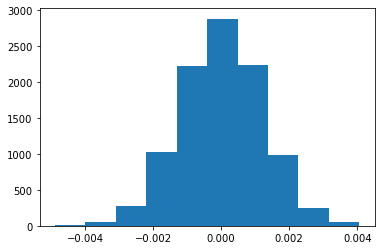

In [36]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
(p_diffs > obs_diff).mean()

0.0931

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> In part j, we computed the probability of obtaining our observed statistic, which in this case is the difference between the probability of conversion of customers who landed in the new page versus the old one in our dataset as shown earlier in Part I, in a simulated population of this difference where the null hypothesis is assumed to be correct.
>
> In scientific studies, this value is called p-value.
>
> Since the p-value is much larger than the type I error threshold at 5%, so we fail to reject the null hypotheses, or in other words, the new landing page does not appear to lead to a higher proportion of conversions than the old page does.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [39]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> z-score of 1.3109 corresponds to a p-value of 0.9050, which means that about 90.50 % of the values in our simulated dataset are lower than our observed statistic. 
>
> Our z-score and p-value through the built-in method are similar to the findings in part j and part k above.
>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
# Creating the ab_page column
df2['intercept'] = 1
df2[['ab_page_temp', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['ab_page_temp'], axis =1 , inplace = True)
df2.head()

/Users/xiaokelaitipalidan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xiaokelaitipalidan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/xiaokelaitipalidan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-01-25 19:36 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

> The p-value for ab_page is 0.19. Therefore we can conclude that the new landing page is not statistically significant in customers' decision whether to convert or not.
>
> It is different from the part II, because we use different hypothesis test in two cases.  In the statistical test, we perform a one-sided hypothesis test whereas in the regression model we perform a two sided hypothesis test. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> The main argument for adding more independent variables into our model is that landing page alone might not be adequate to explain why customers chose to convert or not, and there might be other lurking variables that we have yet to take into account. For example, customers' income, exact time of accessing our page or place of origin can also be other factors that may impact customers' decision. Hence, by adding and examining other factors, we will be able to reduce the potential biases of our previous model.
>
> One of the disadvantages of adding more variables is that multicollinearity may occur as a result. This may lead to our co-efficient values become less accurate, and in some cases even cause the prediction outputs of our relationship between variables to be entirely wrong. For example, we may choose to add a new independent variable for Internet Browsers being used to access our website. Multicollinearity may arise as this new variable can be highly correlated with landing page, for people with older browsers may prefer/ can only access the old page.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns 

In [43]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
df2 = df2.join(df_countries.set_index('user_id'),on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [45]:
# Creating 2 new country columns for the dummy variables.
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.drop('UK', axis = 1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [46]:
df2['intercept'] = 1
log_mod2 = sm.Logit(df2['converted'], df2[['intercept','ab_page', 'US', 'CA']])
results_02 = log_mod2.fit()
results_02.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-01-25 19:36 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

In [47]:
1 / np.exp(-0.0149), 1 / np.exp(-0.0099) , 1/ np.exp(-0.0506)

(1.0150115583846535, 1.009949167117542, 1.0519020483004984)

> After running our model, we can see that the country variables do not affect whether an individual might choose to convert or not, as their p-values are all higher than our threshold of 0.05. Hence, country on its own is not a statistically significant factor in explaining customers' decision.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
# Creating two new columns representing the interaction variables and then running our model.
df2['page_US'] = df2['ab_page'] * df2['US']
df2['page_CA'] = df2['ab_page'] * df2['CA']

md_03 = sm.Logit(df2['converted'], df2[['intercept', 'page_US', 'page_CA']])
results_03 = md_03.fit()
results_03.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212777.1060
Date:               2021-01-25 19:36 BIC:              212808.8450
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.030766   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9873    0.0072  -275.5728  0.0000  -2.0014  -1.9732
page_US      -0.0197    0.0121    -1.6337  0.1023  -0.0434   0.0039
page_CA      -0.0842    0.0378    -2.2251  0.0261  -0.1583  -0.0100
==================================================================

"""

In [49]:
1 / np.exp(-0.0197), 1 / np.exp(-0.0842)

(1.0198953255292176, 1.087846441341616)

> After running our model, it appears that page_CA variable does have a significant effect on conversion rate as its p-value is only 0.026, way below the type I error threshold. More specifically, we can conclude that people who visit the old landing page and are from UK are 1.0878 times more likely to convert than those who land in the new page and are from Canada, provided that all other variables remain constant.

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1